# Libraries
In order to run the code these are the requested libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.spatial.distance import cdist
from scipy.interpolate import make_interp_spline
import heapq
import time

# Random Point Generation
We generate a random set of n sparse points with label -1,1 and then we remove the label from 30% of them

In [70]:
def generate_sparse_points(n, seed, density=0.1):
    # Inputs:
    #   n (int): dimension of the matrix.
    #   seed (int): seed for the random generation.
    #   density (float): density for the generation of the sparse matrix.

    # Output:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].


    # Setting the seed for reproducibility
    np.random.seed(seed)
    
    # Randomly generate a sparse matrix
    A = sparse.random(n, n, density=density, random_state=seed)
    
    # Extract the coordinates from the non-zero elements
    rows, cols = A.nonzero()
    values = A.data
    
    # Map the class of data
    labels = np.where(values < 0.5, '-1', '1')
    
    # Randomly remove the label from 30% of data
    mask = np.random.rand(len(rows)) < 0.5
    labels = np.where(mask, labels, None)
    
    # Create the dataframe
    df = pd.DataFrame({'x': rows,'y': cols,'label': labels})
    
    return df

# Data Plot
Simple look at the distribution of the data

In [71]:
def plot_points(df):
    # Input:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].
    #Output:
    #   Visualize the distribution of the data with a simple plot.
    
    # Splitting the data into classes
    df_A = df[df['label'] == '1']
    df_B = df[df['label'] == '-1']
    df_unlabeled = df[df['label'].isna()]

    # Defining the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_A['x'], df_A['y'], c='blue', label='Cluster 1', marker='o')
    plt.scatter(df_B['x'], df_B['y'], c='red', label='Cluster -1', marker='s')
    plt.scatter(df_unlabeled['x'], df_unlabeled['y'], c='gray', label='Unlabeled', marker='x')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Points Distribution')
    plt.legend()

    # Visualizing the plot
    plt.show()

# BCGD with GS Rule Implementation

## Objective Function
Defining the objective function for the semi-supervised learning task

In [72]:
def create_ssl_objective(df, sigma_w, sigma_bar_w, alpha=1e-6):
    # Inputs:
    #   df (pd.DataFrame): a dataframe with columns ["x","y","label"] with x,y coordinates, label ["-1","1","None"].
    #   sigma_w (float): Sigma for the Gaussian kernel between labelled - unlabelled points.
    #   sigma_bar_w (float): Sigma for the Gaussian kernel between unlabelled points.
    #   alpha (float, optional): Small value added to Q for stability.

    # Outputs:
    #   fast_updates_f (function): function for the fast updates of the objective function and the gradient
    #   safe_updates_f (function): function to compute the objective function and the gradient 
    #   Q (u,u): quadratic matrix of F(y) 
    #   b (u,): linear terms of the objective function

    # Dividing labelled and unlabelled data
    labelled_df = df[df['label'].notna()].copy()
    unlabelled_df = df[df['label'].isna()].copy()

    # Number of labelled points
    l = len(labelled_df) 
    # Number of unlabelled points
    u = len(unlabelled_df) 

    #Extracting coordinates and labels from each point
    labelled_points = labelled_df[['x', 'y']].values
    labelled_y_bar = labelled_df['label'].values.astype(float)
    unlabelled_points = unlabelled_df[['x', 'y']].values

    # The quadratic problem to minimize is F(y) = 0.5*y^T Q y + b^T y + C
    # We need to compute these terms

    # Calculating the weights w_ij (labelled i -> unlabelled j) 
    # The choosen distance measure is the squared euclidean distance
    # This distance is better than the euclidean distance because the derivative and the computation are simpler
    # We obtain a matrix with shape l x u where each element (i,j)=||w_i - x_j||^2
    dist_lu_sq = cdist(labelled_points, unlabelled_points, metric='sqeuclidean')

    # We need to transform the distance measure into a similarity between [0,1]
    # We use an RBF-Kernel to normalize each value in the matrix between 0 and 1 
    # More similar -> 1, more dissimilar values ->0
    W_lu = np.exp(-dist_lu_sq / (2 * sigma_w**2))

    # For each unlabelled point sum the weights of each labelled point
    # Represents how much each unlabelled point is related to all the labelled points
    sum_w_j = np.sum(W_lu, axis=0)

    # Building the diagonal matrix D_w with shape u x u 
    # We will use this matrix in the F(y), inside the Q term
    D_w = np.diag(sum_w_j)

    # Calculating the b term, a vector with shape (u,)
    # b_j = -2 * sum_i (w_ij * y_bar_i)
    b = -2 * W_lu.T @ labelled_y_bar 

    # Second term of the objective function -> similarity between unlabelled examples: 0.5 * sum w_bar_ij (yi - yj)^2 
    # Can be expanded in: sum_i (yi)^2 * (sum_{j!=i} w_bar_ij) - sum_{i, j!=i} w_bar_ij * yi * yj
    # Quadratic component: y^T * (D_smooth - W_smooth) * y
    # D_smooth is diagonal with D_smooth[i,i] = sum_{j!=i} w_bar_ij -> how a point is connected to the others
    # W_smooth weights matrix of w_bar_ij with diagonal 0 -> similarity between points
    # D_smooth - W_smooth -> penalize the difference between similar points

    # Calculating the weights w_bar_ij (unlabelled i -> unlabelled j) 
    # The choosen distance measure is the squared euclidean distance
    # This distance is better than the euclidean distance because the derivative and the computation are simpler
    # We obtain a matrix with shape u x u where each element (i,j)=||w_i - x_j||^2
    W_bar_uu = np.zeros((u, u))
    dist_uu_sq = cdist(unlabelled_points, unlabelled_points, metric='sqeuclidean')

    # We need to transform the distance measure into a similarity between [0,1]
    # We use an RBF-Kernel to normalize each value in the matrix between 0 and 1 
    # More similar -> 1, more dissimilar values ->0
    W_bar_uu = np.exp(-dist_uu_sq / (2 * sigma_bar_w**2))

    # We don't want any self loop similarity 
    np.fill_diagonal(W_bar_uu, 0)

    # Calculating D_smooth (grade matrix) diagonal matrix (u,u)
    # Sum the weight of each row, vector of dimension (u,) -> element i is the sum of similarity between point i and unlabelled j's
    D_smooth_diag = np.sum(W_bar_uu, axis=1)
    D_smooth = np.diag(D_smooth_diag)

    # The quadratic matrix for the second term is (D_smooth - W_bar_uu)

    # Building the full Q matrix
    # F(y) = [y^T D_w y + b^T y] + [y^T (D_smooth - W_bar_uu) y] + constant
    # F(y) = y^T (D_w + D_smooth - W_bar_uu) y + b^T y + constant
    # We want F(y) = 0.5 * y^T Q y + b^T y
    # 0.5 * Q = D_w + D_smooth - W_bar_uu
    # Q = 2 * (D_w + D_smooth - W_bar_uu)

    Q = 2 * (D_w + D_smooth - W_bar_uu)

    # We use the identity matrix to add a regularization term to Q
    Q += alpha * np.eye(u)

    # Defining the objective functions, the gradient and the updates
    # Mapping each variable with the related ones (non null correlation considering alpha)
    dict_nonzeros = {i: np.where(np.abs(Q[:, i]) > 1e-15)[0] for i in range(Q.shape[1])}

    # Calculating the objective function and ignore the constant term
    def f(y):
    # Input:
    #   y: variables to optimize
    # Output:
    #   value (float): value of the objective function in y

        return 0.5 * y.T @ Q @ y + b.T @ y

    # Gradient of the objective function
    def grad_f(y):
    # Input:
    #   y (float): variables to optimize
    # Output:
    #   gx (u,): gradient of the objective function in y

        return Q @ y + b

    # Fast update of fx, gx and the updating variable
    def fast_updates_f(fx, gx, stepsize, idx):
    # Input:
    #   fx (float): current objective function
    #   gx (u,): current gradient
    #   stepsize: update stepsize
    #   idx (array): index of the variable to update
    # Output:
    #   fx (float): updated objective function
    #   gx (u,): updated gradient
    #   list_nonzeros (array): index of variables with updated gradient

        # Find the non zero elements
        list_nonzeros = dict_nonzeros[idx]
        # Descent direction and order
        fx = fx - stepsize * gx[idx] ** 2 + 0.5 * stepsize ** 2 * Q[idx, idx] * gx[idx] ** 2
        # Update the gradient
        gx[list_nonzeros] = gx[list_nonzeros] - stepsize * Q[list_nonzeros, idx] * gx[idx]
        return fx, gx, list_nonzeros

    # Safe update of fx, gx and the updating variable
    def safe_updates_f(y):
    # Input:
    #   y (float): variables to optimize
    # Output:
    #   fx (float): value of the objective function in y
    #   gx (u,): gradient of the objective function in y

        # Calculating the gradient
        gx = grad_f(y)
        # Calculating the objective function
        fx = f(y)
        return fx, gx

    return fast_updates_f, safe_updates_f, Q, b

## Stepsize Strategies
Defining a stepsize strategy function based on the selected strategy and matrix Q.

In [73]:
def stepsize_creator(stepsize_strat, Q):
    # Inputs:
    #   stepsize_strat (string): selected stepsize strategy 
    #   Q (u,u): quadratic term of F(y)
    # Output:
    #   value (float): stepsize strategy function

    if stepsize_strat == 'L':
        # Calculate the spectral norm of Q
        L = np.linalg.norm(Q, ord=2)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the spectral norm
            return 1 / L

    elif stepsize_strat == 'block_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the L2 norm of the corresponding column of Q
            return 1 / vec_norms[i]

    elif stepsize_strat == 'exact':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def stepsize_strat(grad_i, i):
            # Return the stepsize based on the diagonal elements of Q
            return 1 / vec_curvatures[i]

    return stepsize_strat

## Priority Strategies
Calculating the priority of an element based on the selected strategy and matrix Q

In [74]:
def max_priority_generator(priority_type, Q):
    # Inputs:
    #   priority_type (string): selected priority strategy
    #   Q (u,u): quadratic term of F(y)
    # Output:
    #   value (float): priority function

    if priority_type == 'abs':
        def abs_val(val, idx):
            # Calculate the absolute value of the element
            return abs(val)
        return abs_val

    elif priority_type == 'abs_L':
        # Calculate the L2 norms of the columns of Q
        vec_norms = np.linalg.norm(Q, ord=2, axis=0)
        def abs_val_scaled(val, idx):
            # Calculate the absolute value of the element scaled by the L2 norm of the corresponding column of Q
            return abs(val) / vec_norms[idx]
        return abs_val_scaled

    elif priority_type == 'max_improvement':
        # Extract the diagonal of Q
        vec_curvatures = np.diag(Q)
        def improvement(val, idx):
            # Calculate the priority based on the improvement of the objective function value
            return val ** 2 / vec_curvatures[idx]

        return improvement

## Heap Class
Definition of the max heap class in order to correctly use the Gauss-Southwell rule

Without the use of the max heaps the research of the maximum priority element will be O(N), which is less efficient

In [75]:
class Heap:
    def __init__(self, gradient, f_priorities):
        # Initialize the heap with priorities calculated from the given function
        self.f_priorities = f_priorities
        self.heap = [(-f_priorities(val, idx), idx) for idx, val in enumerate(gradient)]
        heapq.heapify(self.heap)  # Convert the list into a heap structure
        # Update the heap structure with positive values for priorities
        self.heap = [(-vali[0], vali[1]) for vali in self.heap]
        # Dictionary containing the index of each element in the heap
        self.dict = {vali[1]: i for (i, vali) in enumerate(self.heap)}

    def get_max(self):
        # Return the element with the maximum priority (first element in the heap)
        return self.heap[0]

    def update_priority(self, idx, new_val):
        # Update the priority of an element at the given index with a new value
        new_priority = self.f_priorities(new_val, idx)
        i = self.dict[idx]  # Get the index of the element in the heap
        old_priority, _ = self.heap[i]  # Get the old priority of the element
        self.heap[i] = (new_priority, idx)  # Update the priority with the new value and index
        if new_priority > old_priority:
            # New priority is higher than the old one, sift up
            while i > 0:
                parent_i = (i - 1) // 2  # Calculate the index of the parent node
                if self.heap[parent_i] < self.heap[i]:
                    # Swap the current node with its parent if the priority is higher
                    heap_parent_i = self.heap[parent_i]
                    self.heap[parent_i] = self.heap[i]
                    self.heap[i] = heap_parent_i
                    # Update the dictionary with the new indices
                    self.dict[self.heap[parent_i][1]], self.dict[self.heap[i][1]] = parent_i, i
                    i = parent_i  # Move to the parent node
                else:
                    break  # Exit the loop if the heap property is satisfied
        else:
            # New priority is lower or equal to the old one, sift down
            while True:
                left_child_i = 2 * i + 1  # Calculate the index of the left child node
                right_child_i = 2 * i + 2  # Calculate the index of the right child node

                # Find the index of the child with the maximum priority
                max_child_i = i
                if left_child_i < len(self.heap) and self.heap[left_child_i] > self.heap[max_child_i]:
                    max_child_i = left_child_i
                if right_child_i < len(self.heap) and self.heap[right_child_i] > self.heap[max_child_i]:
                    max_child_i = right_child_i
                if max_child_i == i:
                    break  # Exit the loop if the heap property is satisfied

                # Swap the current node with the maximum child
                heap_max_child_i = self.heap[max_child_i]
                self.heap[max_child_i] =  self.heap[i]
                self.heap[i] = heap_max_child_i
                # Update the dictionary with the new indices
                self.dict[self.heap[max_child_i][1]], self.dict[self.heap[i][1]] = max_child_i, i
                i = max_child_i  # Move to the maximum child node

## BCGD with GS Rule

In [76]:
def BCGD_GS(fast_updates_f, safe_updates_f, x0, num_iters, tol, f_priorities, stepsize_strat):
    # Inputs:
    #   fast_updates_f (function): fast updates of the objective function
    #   safe_updates_f (function): safe updates of the objective function
    #   x0 (u,): initial solution
    #   num_iters (int): maximum number of iterations
    #   tol (float): tolerance for convergence
    #   f_priorities (function): heap ordering
    #   stepsize_strat (function): step size strategy
    # Outputs:
    #   x (u,): optimal solution
    #   f_history (list): history of the objective function
    #   time_history (list): CPU time history

    # Initialize the solution
    x = x0.copy()

    # Create a max heap for storing the gradients
    fx, grad = safe_updates_f(x)
    heap_gradient = Heap(grad, f_priorities)

    # Starting the tracking of the objective function and the CPU time
    f_history = [fx]
    time_history = [0]
    
    # Iter for num_iters 
    for iter_count in range(num_iters):
        # Store the starting time
        iter_start = time.process_time()
        
        # Extract the feature with the largest gradient with the heap strategy
        max_grad_val, idx = heap_gradient.get_max()

        # Perform a line search along the direction of the largest gradient
        step_size = stepsize_strat(grad[idx], idx)
        x[idx] -= step_size * grad[idx]

        # Update the function informations
        fx, grad, list_updated = fast_updates_f(fx, grad, step_size, idx)

        # Update the history of the objective function
        f_history.append(fx)
        
        # Push the updated gradient components to the heap and update the priority
        for i in list_updated:
            heap_gradient.update_priority(i, grad[i])
        
        # Update the CPU time for the updates
        time_history.append(time_history[-1] + (time.process_time() - iter_start))

        # Check the convergence criterion
        if abs(max_grad_val) < tol:
            break

    return x, f_history, time_history

## Gradient Descent

In [83]:
def GD(safe_updates_f, x0, num_iters, Q, tol):
    """Gradient Descent per il problema di minimizzazione SSL."""
    # Inizializzazione
    x = x0.copy()
    fx, grad = safe_updates_f(x)
    
    # Storia dei valori e tempi
    f_history = [fx]
    time_history = [0]
    
    step_size = 1 / np.linalg.norm(Q, ord=2)  # dove Q viene passato come parametro o calcolato
    
    for iter_count in range(num_iters):
        iter_start = time.process_time()
        
        # Calcola il gradiente completo
        fx, grad = safe_updates_f(x)
        
        # Aggiorna tutte le coordinate contemporaneamente
        x = x - step_size * grad
        
        # Aggiorna la storia
        f_history.append(fx)
        time_history.append(time_history[-1] + (time.process_time() - iter_start))
        
        # Criterio di convergenza
        if np.linalg.norm(grad) < tol:
            break
    
    return x, f_history, time_history

## Coordinate Minimization

In [78]:
def CD(fast_updates_f, safe_updates_f, Q, x0, num_iters, tol):
    """Coordinate Minimization per il problema di minimizzazione SSL."""
    # Inizializzazione
    x = x0.copy()
    fx, grad = safe_updates_f(x)
    n = len(x)
    
    # Storia dei valori e tempi
    f_history = [fx]
    time_history = [0]
    
    # Reset counter for stability
    reset_counter = 0
    
    # Ciclo principale
    for iter_count in range(num_iters):
        iter_start = time.process_time()
        
        # Seleziona l'indice della coordinata da aggiornare
        idx = np.random.randint(0, n)
        
        # Per CD, il calcolo dello step ottimale richiede step positivo
        q_ii = Q[idx, idx]
        if q_ii > 1e-10:  # Verifica stabilità numerica
            stepsize = 1.0 / q_ii  # Stepsize positivo per update
            stepsize = min(1.0, stepsize)  # Limitato per stabilità
        else:
            # Per direzioni quasi piatte, usa uno step piccolo
            stepsize = 0.01
        
        # Aggiornamento in direzione opposta al gradiente
        x[idx] -= stepsize * grad[idx]
        
        # Reset periodico per evitare errori di arrotondamento
        reset_counter += 1
        if reset_counter >= 50:
            fx, grad = safe_updates_f(x)
            reset_counter = 0
        else:
            # Aggiornamento veloce - nota: stepsize è positivo qui
            try:
                fx, grad, _ = fast_updates_f(fx, grad, stepsize, idx)
            except:
                # In caso di errore, reset di sicurezza
                fx, grad = safe_updates_f(x)
                reset_counter = 0
        
        # Aggiorna la storia
        f_history.append(fx)
        time_history.append(time_history[-1] + (time.process_time() - iter_start))
        
        # Criterio di convergenza
        if np.linalg.norm(grad) < tol:
            break
    
    return x, f_history, time_history

## Variables
Defining the variables for the computation

In [79]:
# Defininf the dimension n of the n x n matrix
num_total_points = 100

# Defining the seed
seed = 1

# Sigma for labeled-unlabeled weights
sigma_w = 1.0 

# Sigma for unlabeled-unlabeled weights     
sigma_bar_w = 1.0  

# Regularization for Q (small value > 0)
alpha_reg = 1e-6  

# Maximum number of iterations for BCGD-GS 
num_iters = 3000  

# Tolerance for convergence 
tol = 1e-7         

--- Phase 1: Random Points Generation ---


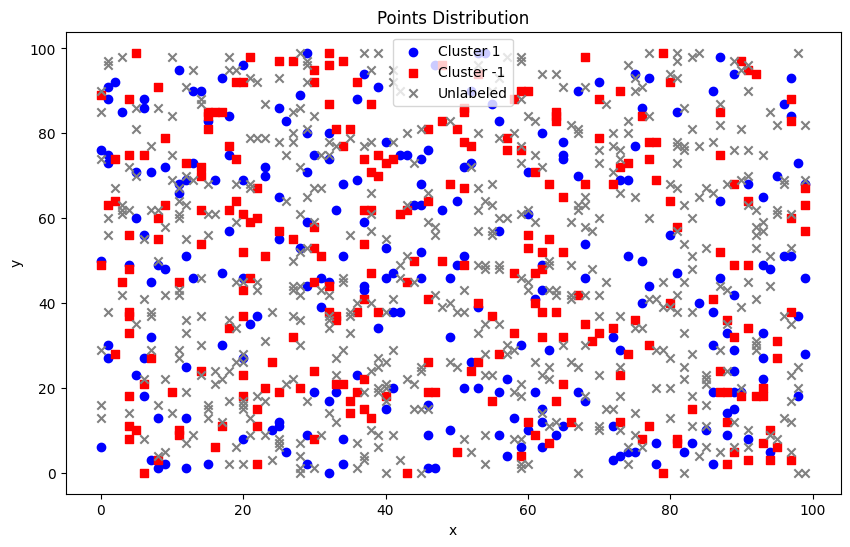


--- Phase 2: Creation of the Optimization Problem ---

--- Phase 3: Optimal Solution Calculation ---

--- Phase 4: Initial guess for unlabelled points ---

--- Phase 5: Running CD Algorithm ---

Running CD with random coordinate selection and exact line search
GD completed -> Final function value: -70.610378

--- Phase 6: Plotting CD Results ---


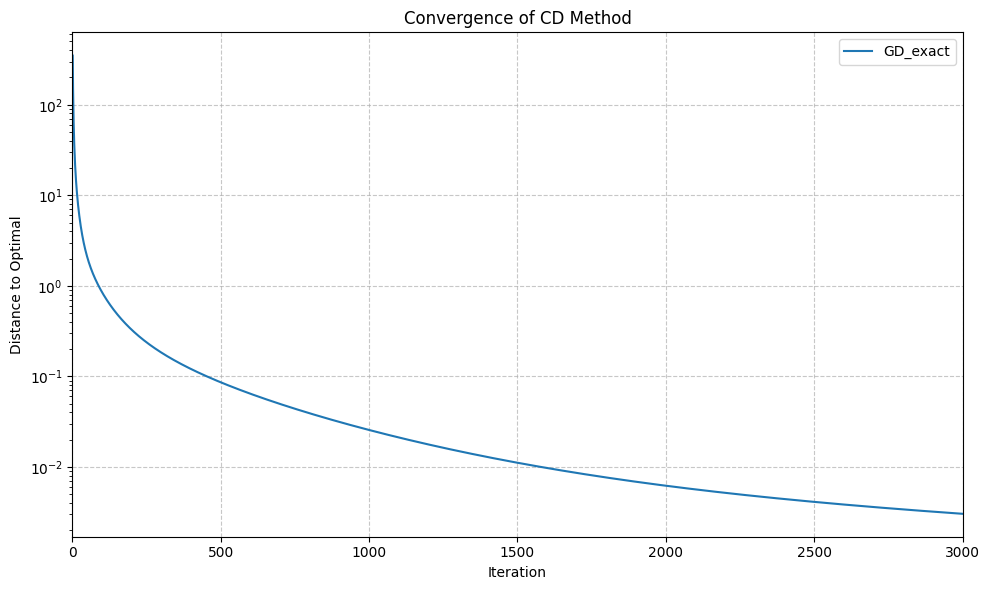

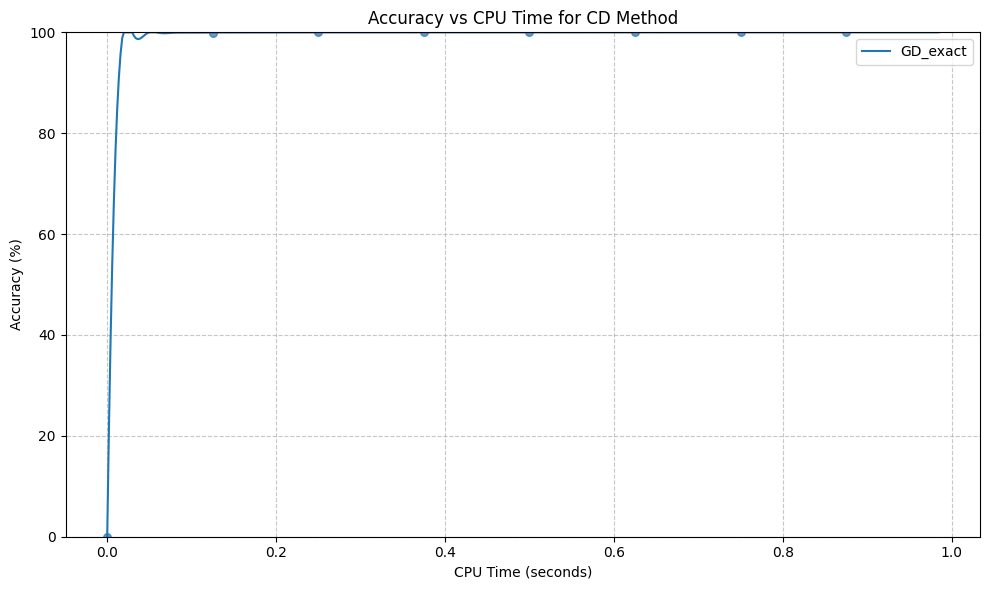


--- Execution Synthetic Data Completed ---


In [84]:
print("--- Phase 1: Random Points Generation ---")
# Create a random set of sparse points
points_df = generate_sparse_points(num_total_points,seed)
plot_points(points_df)

print("\n--- Phase 2: Creation of the Optimization Problem ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running CD Algorithm ---")
# Dictionary for the history
dict_f_history = {}
dict_y_opt = {}
dict_time_history = {}

#def GD(safe_updates_f, x0, num_iters, Q, tol):
# Run the CD solver once (no different strategies needed as CD uses exact line search)
print("\nRunning CD with random coordinate selection and exact line search")
y_opt_current, f_history_current, time_history_current = GD(
    safe_updates_f=safe_updates_f,
    x0=y0.copy(),
    num_iters=num_iters,
    Q=Q.copy(),
    tol=tol
)
dict_f_history["GD_exact"] = f_history_current
dict_y_opt["GD_exact"] = y_opt_current
dict_time_history["GD_exact"] = time_history_current
print(f"GD completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting CD Results ---")

plt.figure(figsize=(10, 6))

# Computing the distances
initial_distances = {}
for method in dict_f_history:
    initial_distances[method] = abs(dict_f_history[method][0] - f_optimal)
max_initial_distance = max(initial_distances.values())

# Error vs Iterations (y in log scale)
for method in dict_f_history:
    # get the function history for the method
    f_history = dict_f_history[method]
    
    # Obtain the distance to optimal solution
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    
    # Extend the last value to num_iters if needed for a better visualization
    full_history = dist_to_optimal.copy()
    if len(full_history) < num_iters + 1:
        full_history += [full_history[-1]] * (num_iters + 1 - len(full_history))
    
    x_values = list(range(num_iters + 1))
    plt.semilogy(x_values, full_history, label=method)

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Distance to Optimal')
plt.title('Convergence of CD Method')
plt.legend()
plt.xlim(0, num_iters)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Second plot: Accuracy vs CPU Time
plt.figure(figsize=(10, 6))

for method in dict_f_history:
    # get the function history and CPU time for the method
    f_history = dict_f_history[method]
    time_history = dict_time_history[method]
    
    # Converting the distance to optimal into accuracy
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    accuracy = [100 * (1 - dist/max_initial_distance) for dist in dist_to_optimal]
    accuracy = [max(0, min(100, acc)) for acc in accuracy]  # Limita tra 0-100%
    
    # Apply interpolation for a smoother plot
    time_acc_pairs = sorted(zip(time_history, accuracy))
    unique_times = []
    unique_accuracies = []
    prev_time = -1
    for t, a in time_acc_pairs:
        if t != prev_time:
            unique_times.append(t)
            unique_accuracies.append(a)
            prev_time = t

    if len(unique_times) > 3:
        x_smooth = np.linspace(min(unique_times), max(unique_times), 500)
        k = min(3, len(unique_times)-1)
        if k > 0:
            spline = make_interp_spline(unique_times, unique_accuracies, k=k)
            y_smooth = spline(x_smooth)
            y_smooth = np.clip(y_smooth, 0, 100)
            plt.plot(x_smooth, y_smooth, label=method)
            stride = max(1, len(unique_times) // 8)
            plt.scatter(unique_times[::stride], unique_accuracies[::stride], s=30, alpha=0.7)
        else:
            plt.plot(unique_times, unique_accuracies, label=method)
    else:
        plt.plot(unique_times, unique_accuracies, label=method)

# Add labels and title to plot
plt.xlabel('CPU Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs CPU Time for CD Method')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\n--- Execution Synthetic Data Completed ---")

## Computation of BCGD_GS on Artificial Data
The synthetic data used are completely random and sparse

We removed the label from the 50% of the data

--- Phase 1: Random Points Generation ---


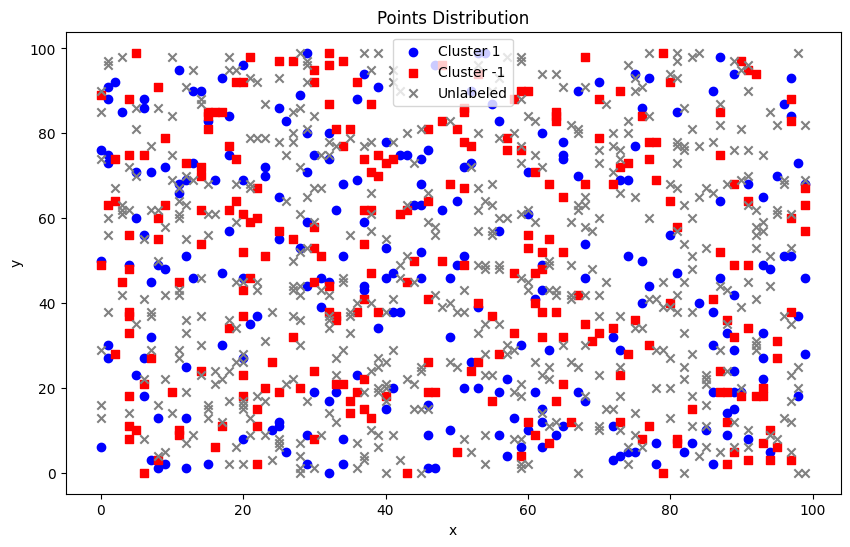


--- Phase 2: Creation of the Optimization Problem ---

--- Phase 3: Optimal Solution Calculation ---

--- Phase 4: Initial guess for unlabelled points ---

--- Phase 5: Running BCGD-GS with Different Strategies ---

Running strategy: L+abs
Strategy L+abs completed -> Final function value: -59.960964

Running strategy: block_L+abs_L
Strategy block_L+abs_L completed -> Final function value: -70.391948

Running strategy: exact+max_improvement
Strategy exact+max_improvement completed -> Final function value: -70.480314

--- Phase 6: Plotting BCGS-GS Results ---


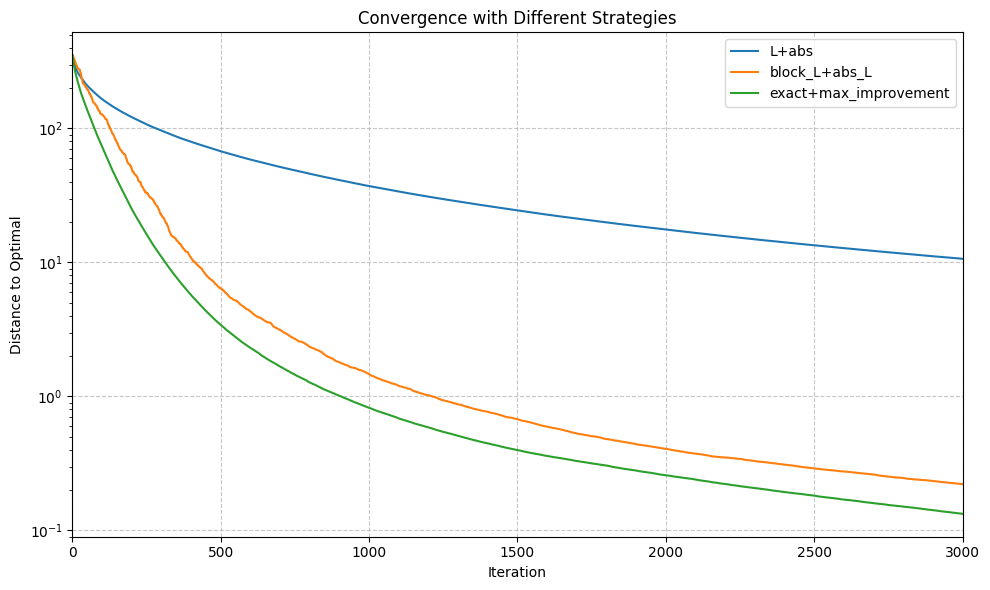

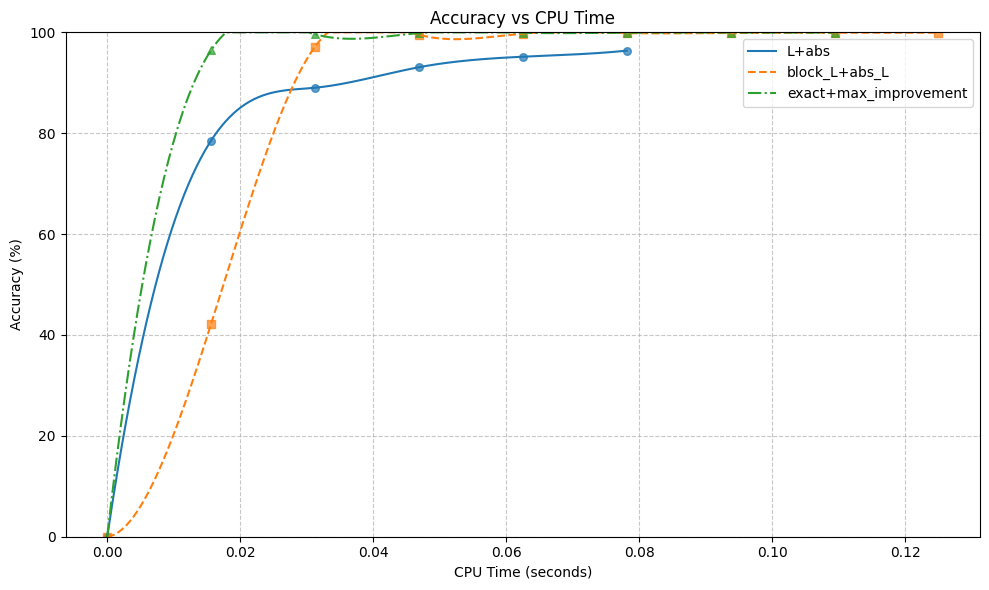


--- Execution Synthetic Data Completed ---


In [81]:
print("--- Phase 1: Random Points Generation ---")
# Create a random set of sparse points
points_df = generate_sparse_points(num_total_points,seed)
plot_points(points_df)

print("\n--- Phase 2: Creation of the Optimization Problem ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running BCGD-GS with Different Strategies ---")
# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']
vec_priority_strats = ['abs', 'abs_L', 'max_improvement']

# Dictionaries for the history
dict_f_history = {}
dict_y_opt = {}
dict_time_history = {}

for step_strat_name, prio_strat_name in zip(vec_stepsize_strats, vec_priority_strats):
    strategy = step_strat_name + '+' + prio_strat_name
    print(f"\nRunning strategy: {strategy}")

    # Create the specific functions for stepsize and priority using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)
    priority_func = max_priority_generator(prio_strat_name, Q)

    # Run the BCGD-GS solver
    y_opt_current, f_history_current, time_history_current = BCGD_GS(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0.copy(),
        num_iters=num_iters,
        tol=tol,
        f_priorities=priority_func,
        stepsize_strat=stepsize_func
    )
    dict_f_history[strategy] = f_history_current
    dict_y_opt[strategy] = y_opt_current
    dict_time_history[strategy] = time_history_current
    print(f"Strategy {strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting BCGS-GS Results ---")

plt.figure(figsize=(10, 6))

# Computing the distances
initial_distances = {}
for strategy in dict_f_history:
    initial_distances[strategy] = abs(dict_f_history[strategy][0] - f_optimal)
max_initial_distance = max(initial_distances.values())

# First subplot: Error vs Iterations (y in log scale)
for i in range(len(vec_stepsize_strats)):
    stepsize_strat = vec_stepsize_strats[i]
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    
    # get the function history for the strategy
    f_history = dict_f_history[strategy]
    
    # Obtain the distance to optimal solution
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    
    # Extend the last value to num_iters if needed for a better visualization
    full_history = dist_to_optimal.copy()
    if len(full_history) < num_iters + 1:
        full_history += [full_history[-1]] * (num_iters + 1 - len(full_history))
    
    x_values = list(range(num_iters + 1))
    plt.semilogy(x_values, full_history, label=strategy)

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Distance to Optimal')
plt.title('Convergence with Different Strategies')
plt.legend()
plt.xlim(0, num_iters)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Second plot: Accuracy vs CPU Time

plt.figure(figsize=(10, 6))

styles = ['-', '--', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for i in range(len(vec_stepsize_strats)):
    stepsize_strat = vec_stepsize_strats[i]
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    
    # get the function history and CPU time for the strategy
    f_history = dict_f_history[strategy]
    time_history = dict_time_history[strategy]
    
    # Converting the distance to optimal into accuracy
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    accuracy = [100 * (1 - dist/max_initial_distance) for dist in dist_to_optimal]
    accuracy = [max(0, min(100, acc)) for acc in accuracy]  # Limita tra 0-100%
    
    # Apply interpolation for a smoother plot
    time_acc_pairs = sorted(zip(time_history, accuracy))
    unique_times = []
    unique_accuracies = []
    prev_time = -1
    for t, a in time_acc_pairs:
        if t != prev_time:
            unique_times.append(t)
            unique_accuracies.append(a)
            prev_time = t

    if len(unique_times) > 3:
        x_smooth = np.linspace(min(unique_times), max(unique_times), 500)
        k = min(3, len(unique_times)-1)
        if k > 0:
            spline = make_interp_spline(unique_times, unique_accuracies, k=k)
            y_smooth = spline(x_smooth)
            y_smooth = np.clip(y_smooth, 0, 100)
            plt.plot(x_smooth, y_smooth, label=strategy, 
                    color=colors[i], linestyle=styles[i])
            stride = max(1, len(unique_times) // 8)
            plt.scatter(unique_times[::stride], unique_accuracies[::stride], 
                       color=colors[i], marker=markers[i], s=30, alpha=0.7)
        else:
            plt.plot(unique_times, unique_accuracies, label=strategy, 
                    color=colors[i], linestyle=styles[i], marker=markers[i])
    else:
        plt.plot(unique_times, unique_accuracies, label=strategy, 
                color=colors[i], linestyle=styles[i], marker=markers[i])

# Add labels and title to plot
plt.xlabel('CPU Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs CPU Time')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Execution Synthetic Data Completed ---")

## Computation of BCGD_GS on Real Data
The selected dataset if from Uber drivers in New York

We removed the label from the 50% of the data

--- Phase 1: Random Points Generation ---


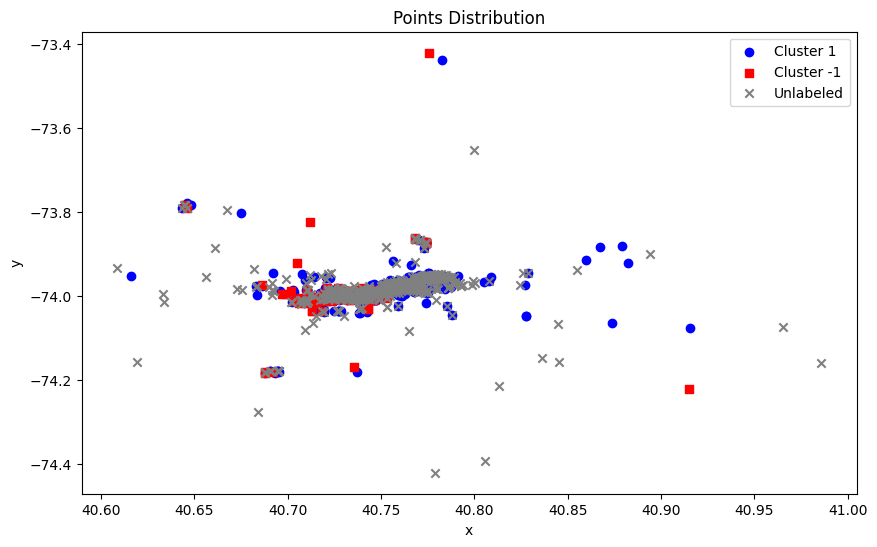


--- Phase 2: Creation of the Optimization Problem ---

--- Phase 3: Optimal Solution Calculation ---

--- Phase 4: Initial guess for unlabelled points ---

--- Phase 5: Running BCGD-GS with Different Strategies ---

Running strategy: L+abs
Strategy L+abs completed -> Final function value: -76127.201658

Running strategy: block_L+abs_L
Strategy block_L+abs_L completed -> Final function value: -76127.202387

Running strategy: exact+max_improvement
Strategy exact+max_improvement completed -> Final function value: -76127.202444

--- Phase 6: Plotting BCGS-GS Results ---


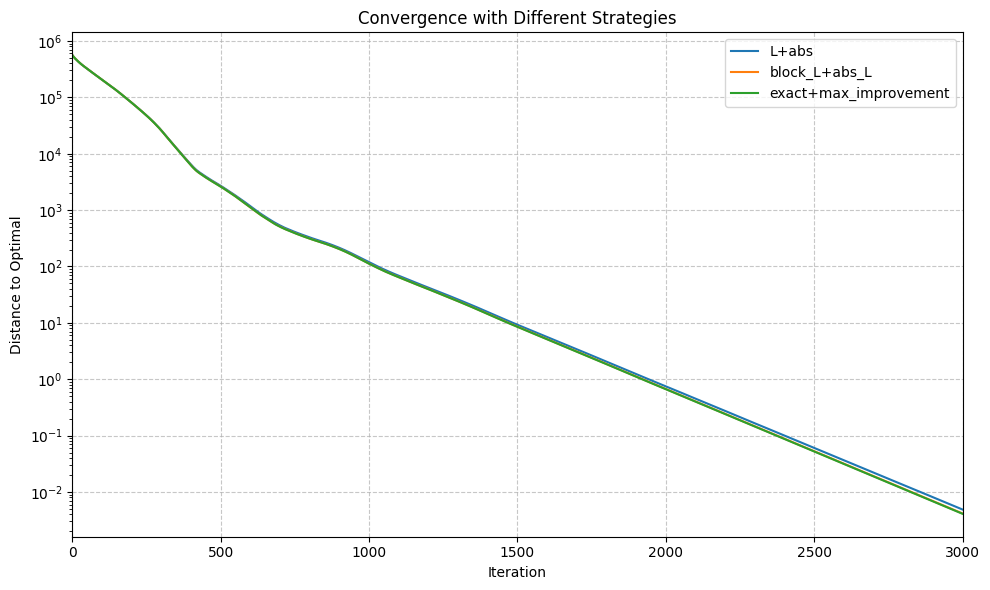

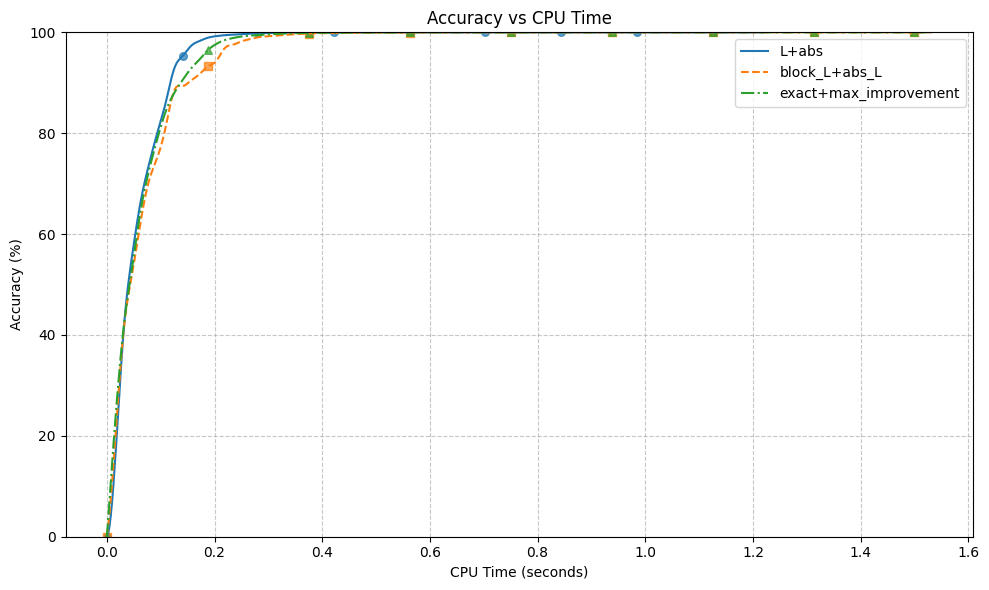


--- Execution on Real Data Completed ---


In [82]:
print("--- Phase 1: Random Points Generation ---")
points_df = pd.read_csv("./uber_small.csv", header=None, names=['x', 'y', 'label'])
points_df['label'] = points_df['label'].map({'A': "1", 'B': "-1"})
np.random.seed(1)
mask = np.random.rand(len(points_df)) < 0.5
points_df.loc[mask, 'label'] = None
plot_points(points_df)

print("\n--- Phase 2: Creation of the Optimization Problem ---")
# Creation of the optimization problem
fast_updates_f, safe_updates_f, Q, b = create_ssl_objective(
    points_df, sigma_w, sigma_bar_w, alpha_reg
)
# Number of unlabelled points
u = Q.shape[0]

print("\n--- Phase 3: Optimal Solution Calculation ---")
# Solve the linear system Qy = -b
y_optimal = np.linalg.solve(Q, -b)

# Calculate the optimal value of the function F(y)
f_optimal = 0.5 * y_optimal.T @ Q @ y_optimal + b.T @ y_optimal

print("\n--- Phase 4: Initial guess for unlabelled points ---")
np.random.seed(1)
y0 = np.random.randn(u)

print("\n--- Phase 5: Running BCGD-GS with Different Strategies ---")
# Strategies to compare
vec_stepsize_strats = ['L', 'block_L', 'exact']
vec_priority_strats = ['abs', 'abs_L', 'max_improvement']

# Dictionaries for the history
dict_f_history = {}
dict_y_opt = {}
dict_time_history = {}

for step_strat_name, prio_strat_name in zip(vec_stepsize_strats, vec_priority_strats):
    strategy = step_strat_name + '+' + prio_strat_name
    print(f"\nRunning strategy: {strategy}")

    # Create the specific functions for stepsize and priority using the calculated Q
    stepsize_func = stepsize_creator(step_strat_name, Q)
    priority_func = max_priority_generator(prio_strat_name, Q)

    # Run the BCGD-GS solver
    y_opt_current, f_history_current, time_history_current = BCGD_GS(
        fast_updates_f=fast_updates_f,
        safe_updates_f=safe_updates_f,
        x0=y0.copy(),
        num_iters=num_iters,
        tol=tol,
        f_priorities=priority_func,
        stepsize_strat=stepsize_func
    )
    dict_f_history[strategy] = f_history_current
    dict_y_opt[strategy] = y_opt_current
    dict_time_history[strategy] = time_history_current
    print(f"Strategy {strategy} completed -> Final function value: {f_history_current[-1]:.6f}")

print("\n--- Phase 6: Plotting BCGS-GS Results ---")

plt.figure(figsize=(10, 6))

# Computing the distances
initial_distances = {}
for strategy in dict_f_history:
    initial_distances[strategy] = abs(dict_f_history[strategy][0] - f_optimal)
max_initial_distance = max(initial_distances.values())

# First subplot: Error vs Iterations (y in log scale)
for i in range(len(vec_stepsize_strats)):
    stepsize_strat = vec_stepsize_strats[i]
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    
    # get the function history for the strategy
    f_history = dict_f_history[strategy]
    
    # Obtain the distance to optimal solution
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    
    # Extend the last value to num_iters if needed for a better visualization
    full_history = dist_to_optimal.copy()
    if len(full_history) < num_iters + 1:
        full_history += [full_history[-1]] * (num_iters + 1 - len(full_history))
    
    x_values = list(range(num_iters + 1))
    plt.semilogy(x_values, full_history, label=strategy)

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Distance to Optimal')
plt.title('Convergence with Different Strategies')
plt.legend()
plt.xlim(0, num_iters)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Second plot: Accuracy vs CPU Time

plt.figure(figsize=(10, 6))

styles = ['-', '--', '-.']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for i in range(len(vec_stepsize_strats)):
    stepsize_strat = vec_stepsize_strats[i]
    priority = vec_priority_strats[i]
    strategy = stepsize_strat + '+' + priority
    
    # get the function history and CPU time for the strategy
    f_history = dict_f_history[strategy]
    time_history = dict_time_history[strategy]
    
    # Converting the distance to optimal into accuracy
    dist_to_optimal = [abs(val - f_optimal) for val in f_history]
    accuracy = [100 * (1 - dist/max_initial_distance) for dist in dist_to_optimal]
    accuracy = [max(0, min(100, acc)) for acc in accuracy]  # Limita tra 0-100%
    
    # Apply interpolation for a smoother plot
    time_acc_pairs = sorted(zip(time_history, accuracy))
    unique_times = []
    unique_accuracies = []
    prev_time = -1
    for t, a in time_acc_pairs:
        if t != prev_time:
            unique_times.append(t)
            unique_accuracies.append(a)
            prev_time = t

    if len(unique_times) > 3:
        x_smooth = np.linspace(min(unique_times), max(unique_times), 500)
        k = min(3, len(unique_times)-1)
        if k > 0:
            spline = make_interp_spline(unique_times, unique_accuracies, k=k)
            y_smooth = spline(x_smooth)
            y_smooth = np.clip(y_smooth, 0, 100)
            plt.plot(x_smooth, y_smooth, label=strategy, 
                    color=colors[i], linestyle=styles[i])
            stride = max(1, len(unique_times) // 8)
            plt.scatter(unique_times[::stride], unique_accuracies[::stride], 
                       color=colors[i], marker=markers[i], s=30, alpha=0.7)
        else:
            plt.plot(unique_times, unique_accuracies, label=strategy, 
                    color=colors[i], linestyle=styles[i], marker=markers[i])
    else:
        plt.plot(unique_times, unique_accuracies, label=strategy, 
                color=colors[i], linestyle=styles[i], marker=markers[i])

# Add labels and title to plot
plt.xlabel('CPU Time (seconds)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs CPU Time')
plt.legend()
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Execution on Real Data Completed ---")